#**Imports**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np


from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

#**Dataset**

In [2]:
df_train = pd.read_csv("Dataset/housing_coursework_train.csv", encoding="ISO-8859-1")
df_test = pd.read_csv("Dataset/housing_coursework_test.csv", encoding="ISO-8859-1")


In [3]:
df_train.head(10)

,No.,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,1,-122.21,37.83,34,5065,788.0,1627,766,6.8976,333300,NEAR BAY
1,2,-122.22,37.77,52,391,128.0,520,138,1.6471,95000,NEAR BAY
2,3,-122.23,37.79,30,610,145.0,425,140,1.6198,122700,NEAR BAY
3,4,-122.20,37.78,52,2300,443.0,1225,423,3.5398,158400,NEAR BAY
4,5,-122.19,37.79,50,954,217.0,546,201,2.6667,172800,NEAR BAY
5,6,-122.19,37.76,26,1293,297.0,984,303,1.9479,85800,NEAR BAY
6,7,-122.17,37.74,43,818,193.0,494,179,2.4776,101600,NEAR BAY
7,8,-122.18,37.75,46,941,218.0,621,195,1.3250,87100,NEAR BAY
8,9,-122.16,37.75,38,2457,624.0,1516,482,1.5625,91700,NEAR BAY
9,10,-122.14,37.75,33,1334,200.0,579,202,6.8323,255900,NEAR BAY


In [4]:
def scatter_plot(feature, target):
    plt.figure(figsize=(8, 4))
    plt.scatter(
        df_train[feature],
        df_train[target],
        c='black'
    )
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.show()

#**Preprocessing**

In [5]:
#Detecting NaN vaues
print("Trainin set: \n",df_train.loc[df_train.isnull().any(axis=1)])
print("Test set: \n",df_test.loc[df_test.isnull().any(axis=1)])

Trainin set: 
      No.  longitude  latitude  housing_median_age  total_rooms  \
72    73    -122.08     37.88                  26         2947   
168  169    -118.28     34.25                  29         2559   
236  237    -118.38     34.05                  49          702   
548  549    -117.87     33.83                  27         2287   
621  622    -116.21     33.75                  22          894   
740  741    -117.02     32.66                  19          771   
786  787    -122.45     37.77                  52         2602   
792  793    -122.50     37.75                  45         1620   

     total_bedrooms  population  households  median_income  \
72              NaN         825         626         2.9330   
168             NaN        1886         769         2.6036   
236             NaN         458         187         4.8958   
548             NaN        1140         351         5.6163   
621             NaN         830         202         3.0673   
740             Na

In [6]:
#Filling Nan total_bedrooms data points with the average total_bedrooms to dampen their effect.
# average_total_bedrooms = df_train['total_bedrooms'].mean()
# df_train.loc[df_train['total_bedrooms'].isnull(),'total_bedrooms'] = average_total_bedrooms

# average_total_bedrooms = df_test['total_bedrooms'].mean()
# df_test.loc[df_test['total_bedrooms'].isnull(),'total_bedrooms'] = average_total_bedrooms

df_train['Sex']=df_train['Sex'].apply(lambda x: 1 if x=='male' else 0)


564.3939393939394


In [553]:
#Shuffle dataset
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train.head(10)

df_test = df_test.sample(frac=1).reset_index(drop=True)
df_test.head(10)


,No.,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,819,-121.17,37.82,35,2506,406.0,1316,398,3.8472,197600,INLAND
1,935,-122.68,38.36,8,7520,1336.0,3833,1287,4.3278,184100,<1H OCEAN
2,824,-120.70,35.28,14,3768,682.0,1884,664,4.6071,239900,NEAR OCEAN
3,978,-119.40,36.55,19,3000,628.0,2202,590,2.5141,67400,INLAND
4,959,-120.98,37.68,27,4006,762.0,1806,718,3.1848,112800,INLAND
5,816,-121.12,37.73,35,1107,227.0,573,210,2.3924,102200,INLAND
6,910,-122.00,36.97,30,1029,242.0,753,249,3.1205,240500,NEAR OCEAN
7,885,-121.99,37.27,21,1214,192.0,500,185,7.5980,347800,<1H OCEAN
8,952,-120.86,37.77,38,1545,279.0,662,266,3.8250,96400,INLAND
9,955,-121.04,37.67,16,19,19.0,166,9,0.5360,162500,INLAND


In [554]:
# Integer encoding ocean proximity
df_train['ocean_proximity']=np.where(df_train['ocean_proximity'] == 'INLAND', 0,
                            np.where(df_train['ocean_proximity'] == '<1H OCEAN', 1,
                            np.where(df_train['ocean_proximity'] == 'NEAR OCEAN', 2,
                            np.where(df_train['ocean_proximity'] == 'NEAR BAY', 3 , df_train['ocean_proximity']))))

df_test['ocean_proximity']=np.where(df_test['ocean_proximity'] == 'INLAND', 0,
                            np.where(df_test['ocean_proximity'] == '<1H OCEAN', 1,
                            np.where(df_test['ocean_proximity'] == 'NEAR OCEAN', 2,
                            np.where(df_test['ocean_proximity'] == 'NEAR BAY', 3 , df_test['ocean_proximity']))))                           
df_train.head(10)

,No.,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,36,-122.05,37.57,7,10648,1818.0,6075,1797,6.1047,278200,3
1,411,-118.35,33.91,19,1949,559.0,1282,498,2.7813,231300,1
2,278,-118.30,33.86,35,2016,365.0,1083,369,5.1727,230200,1
3,637,-121.42,38.64,44,1728,367.0,1042,349,1.6033,58500,0
4,543,-117.79,33.75,26,2893,345.0,983,326,13.4660,500001,1
5,281,-118.28,33.75,18,393,189.0,429,188,1.8393,187500,2
6,738,-117.06,32.61,24,4369,1353.0,3123,1247,2.0571,152300,2
7,338,-118.07,34.16,35,2459,438.0,970,437,4.2143,369400,0
8,507,-117.83,33.88,23,2365,355.0,1209,347,6.0132,259400,1
9,385,-118.07,33.86,17,3666,562.0,2104,579,5.6818,338900,1


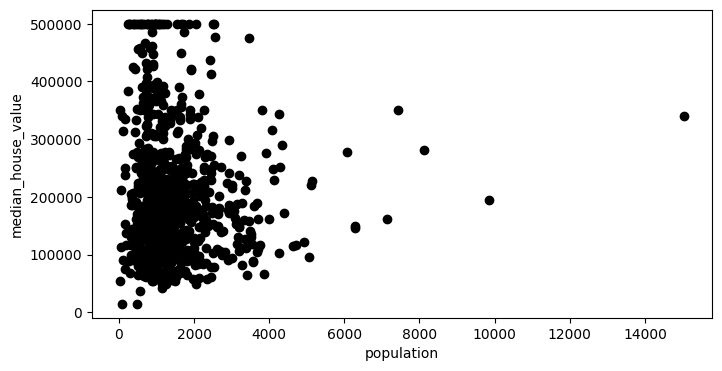

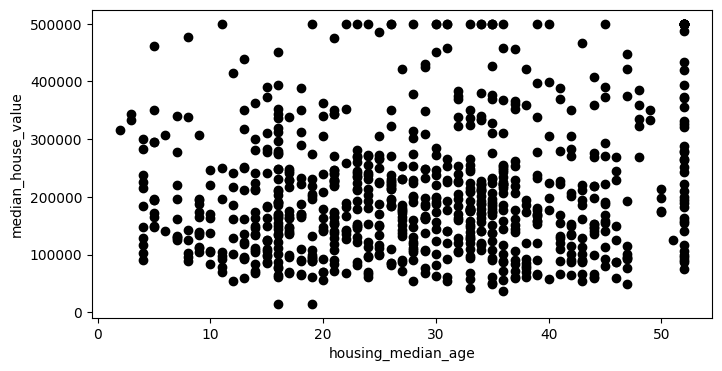

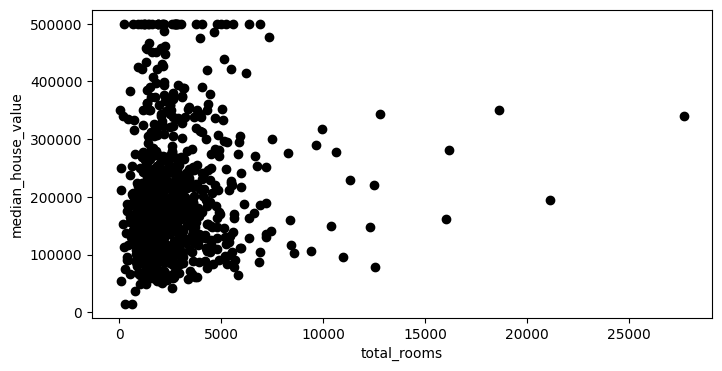

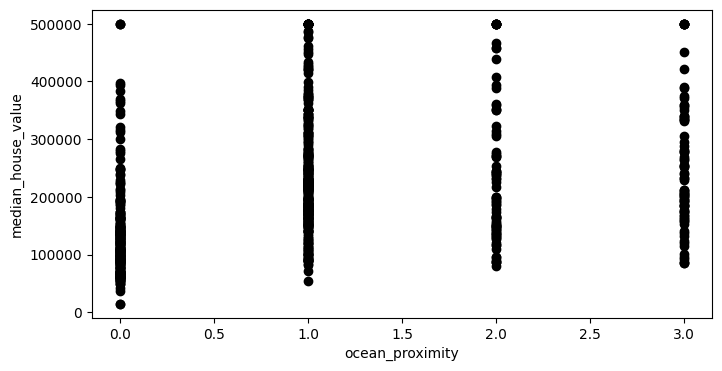

In [555]:
#Attempting to identifying linear relations
scatter_plot('population', 'median_house_value')
scatter_plot('housing_median_age', 'median_house_value')
scatter_plot('total_rooms', 'median_house_value')
scatter_plot('ocean_proximity', 'median_house_value')



In [556]:
# Dropping unnecessary columns
df_train= df_train.drop(columns=['No.'])


df_test = df_test.drop(columns=['No.'])

df_train.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.05,37.57,7,10648,1818.0,6075,1797,6.1047,278200,3
1,-118.35,33.91,19,1949,559.0,1282,498,2.7813,231300,1
2,-118.30,33.86,35,2016,365.0,1083,369,5.1727,230200,1
3,-121.42,38.64,44,1728,367.0,1042,349,1.6033,58500,0
4,-117.79,33.75,26,2893,345.0,983,326,13.4660,500001,1
5,-118.28,33.75,18,393,189.0,429,188,1.8393,187500,2
6,-117.06,32.61,24,4369,1353.0,3123,1247,2.0571,152300,2
7,-118.07,34.16,35,2459,438.0,970,437,4.2143,369400,0
8,-117.83,33.88,23,2365,355.0,1209,347,6.0132,259400,1
9,-118.07,33.86,17,3666,562.0,2104,579,5.6818,338900,1


#**Train**

In [557]:
#Splitting the data
X_train= df_train.drop(columns=['median_house_value'])

y_train= df_train['median_house_value']

X_test= df_test.drop(columns=['median_house_value'])
y_test= df_test['median_house_value']

#**Tuning**

In [558]:
# Trial and error tuning through GridSearch

parameters = {'alpha': [0, 0.1, 0.2, 0.3 ,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
lasso_grid = GridSearchCV(Lasso(), parameters,refit=True,verbose=0,scoring='r2', cv = 5)
lasso_grid.fit(X_train,y_train)

c:\Users\Ahmed\Desktop\ML\env\Lib\site-packages\sklearn\model_selection\_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Ahmed\Desktop\ML\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\Ahmed\Desktop\ML\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.514e+12, tolerance: 7.784e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV inst

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                   0.9, 1]},
             scoring='r2')

C:\Users\Ahmed\AppData\Local\Temp\ipykernel_21400\3721815024.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(rsq_test, 'bo-', label="Training data", color='blue')


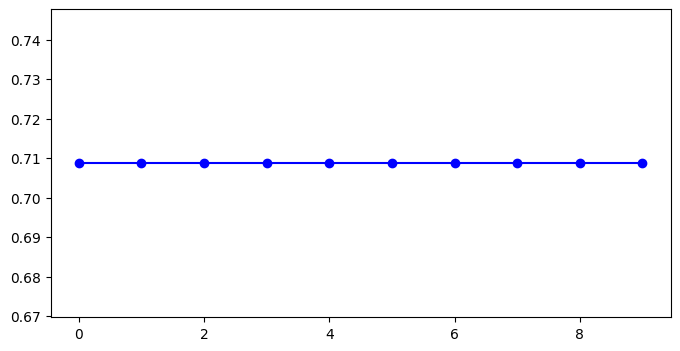

In [572]:
min = 0.01
max = 0.2
num = 10

lambdas = np.linspace(min, max, num)

rsq_train = np.zeros(num) 
rsq_test= np.zeros(num) 
pred_num = X_train.shape[1]
coef_a = np.zeros((num, pred_num))

for ind, i in enumerate(lambdas):
    lasso_mod = Lasso(alpha=i).fit(X_train, y_train)
    scores_1 = cross_val_score(lasso_mod, X_train, y_train, cv=10, scoring='r2')
    rsq_train[ind] = np.round(lasso_mod.score(X_train, y_train),2)
    rsq_test[ind] = np.round(lasso_mod.score(X_test, y_test),4)

plt.figure(figsize=(8,4))
plt.plot(rsq_test, 'bo-', label="Training data", color='blue')

In [559]:
# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, max_iter=1000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5)

In [560]:
print("Best parameters:", lasso_grid.best_params_)
print("Accuracy:", lasso_grid.score(X_test,y_test))

Best parameters: {'alpha': 1}
Accuracy: 0.70869918127017


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


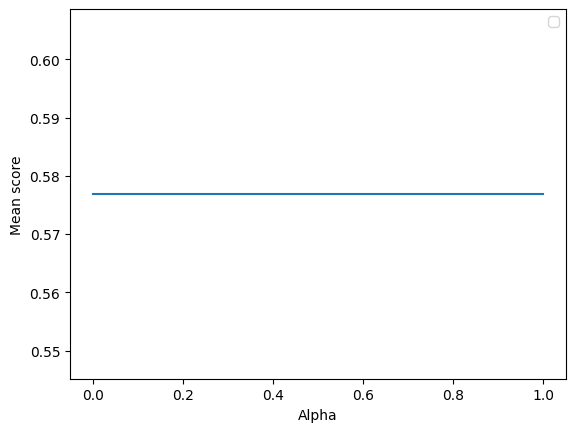

In [561]:
plt.plot(parameters['alpha'], np.round(lasso_grid.cv_results_['mean_test_score'],4))
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean score')
plt.show()

#**Training with tuned parameters**

In [562]:
best_alpha = lasso_grid.best_params_['alpha']
tuned_lasso= Lasso(alpha=best_alpha)

In [563]:
tuned_lasso.fit(X_train,y_train)

Lasso(alpha=1)

#**Final Test**

In [564]:
y_pred_SVM= tuned_lasso.predict(X_test)
print(r2_score(y_test, y_pred_SVM))

0.70869918127017


#**Persistence**

In [565]:
#Save model to disk
filepath = './models/mainmodel.sav'
pickle.dump(tuned_lasso, open(filepath, 'wb'))

In [566]:
#Load saved model from disk
filepath = './models/mainmodel.sav'
loaded_model = pickle.load(open(filepath, 'rb'))
result = loaded_model.score(X_test, y_test)

In [567]:
print(df_test['median_house_value'].head(1))

y_pred_SVM= loaded_model.predict(X_test)
print("GridSearch:")
print(r2_score(y_test, y_pred_SVM))

print(loaded_model.predict(X_test.head(1)))

y_pred_SVM= model.predict(X_test)

print("Cross Validation:")
print(r2_score(y_test, y_pred_SVM))
print(model.predict(X_test.head(1)))



0    197600
Name: median_house_value, dtype: int64
GridSearch:
0.70869918127017
[172366.85051863]
Cross Validation:
0.5342113013478702
[199084.77983467]
